In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from get_utils import get_data, get_dir
import plot as plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


#%matplotlib widget
%matplotlib qt
# %matplotlib inline

In [2]:
from dPCA import dPCA
from sklearn.decomposition import PCA
import torch as th
import pandas as pd
import seaborn as sns

fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20
save_fig = os.path.join(os.path.expanduser('~'),'Dropbox/Projects/papers/MotorSavings/paper/figures_raw')

In [3]:
mo=14
model_name = f'model{mo:02d}'
folder_name = 'Sim_fixed_128'
data = get_data(folder_name,model_name,is_channel=False,n_hidden=128,ff_coef=[8,8,8,8])
X = np.concatenate([np.array(d['all_hidden'][:,None,:,:]) for d in data], axis=1)
# X shape: (movements, conditions, time, neurons) = (8, 4, 100, 128)

[2026-01-17 18:24:39,185] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2026-01-17 18:24:39,185] torch._dynamo.convert_frame: [WARNING]    function: '_integrate' (/Users/mahdiyarshahbazi/Documents/GitHub/MotorNet/motornet/muscle.py:570)
[2026-01-17 18:24:39,185] torch._dynamo.convert_frame: [WARNING]    last reason: ___guarded_code.valid
[2026-01-17 18:24:39,185] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2026-01-17 18:24:39,185] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
[2026-01-17 18:24:39,191] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2026-01-17 18:24:39,191] torch._dynamo.convert_frame: [WARNING]    function: 'clip_activation' (/Users/mahdiyarshahbazi/Documents/GitHub/MotorNet/motornet/muscle.py:62)
[2026-01-17 18:24:39,191] torch._dynamo.conver

In [15]:
# NF1 vs NF2
cond1_idx, cond2_idx = 0, 2
cond1_name, cond2_name = 'NF1', 'NF2'
go_cue, end_time = 0, 100

X_cond1 = X[:, cond1_idx, go_cue:end_time, :]
X_cond2 = X[:, cond2_idx, go_cue:end_time, :]

mean_cond1 = np.mean(X_cond1, axis=(0, 1))
X_cond1_centered = X_cond1 - mean_cond1[None, None, :]
X_cond2_centered = X_cond2 - mean_cond1[None, None, :]

pca = PCA(n_components=3)
pca.fit(X_cond1_centered.reshape(-1, 128))

colormap = plt.cm.viridis
colors = [colormap(i/7) for i in range(8)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

go_cue_idx = 50 - go_cue  # Index where execution starts

for mov in range(8):
    traj1 = pca.transform(X_cond1_centered[mov])
    traj2 = pca.transform(X_cond2_centered[mov])
    
    # NF1 trajectories (solid)
    ax.plot(traj1[:, 0], traj1[:, 1], traj1[:, 2], color=colors[mov], linewidth=2, alpha=0.8)
    ax.scatter(traj1[0, 0], traj1[0, 1], traj1[0, 2], color='black', s=50, marker='o', edgecolors='k', linewidths=1)
    ax.scatter(traj1[go_cue_idx, 0], traj1[go_cue_idx, 1], traj1[go_cue_idx, 2], color=colors[mov], s=100, marker='*', edgecolors='k', linewidths=2)
    
    # NF2 trajectories (dashed)
    ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], color=colors[mov], linewidth=2, linestyle='--', alpha=0.8)
    ax.scatter(traj2[0, 0], traj2[0, 1], traj2[0, 2], color='black', s=50, marker='o', edgecolors='k', linewidths=1)
    ax.scatter(traj2[go_cue_idx, 0], traj2[go_cue_idx, 1], traj2[go_cue_idx, 2], color=colors[mov], s=100, marker='*', edgecolors='k', linewidths=2)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=2, label='FF1 (batch 0)'),
    Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='FF2 (batch 0)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, 
          markeredgecolor='k', markeredgewidth=1, label='Start', linestyle='None'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=10, 
          markeredgecolor='k', markeredgewidth=2, label='Go cue', linestyle='None')
]
ax.legend(handles=legend_elements, fontsize=fontsize_legend, frameon=False)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=fontsize_label)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=fontsize_label)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=fontsize_label)
# ax.set_title(f'{cond1_name} vs {cond2_name}', fontsize=fontsize_label)
plt.show()


In [ ]:
# dPCA comparison - general code
cond1_idx, cond2_idx = 0, 3  # Change to 0, 2 for NF1 vs NF2
cond1_name, cond2_name = 'NF1', 'FF2'  # Change to 'NF1', 'NF2' as needed

model_name = 'model00'
U = get_data(folder_name, model_name, is_channel=False, n_hidden=128)

X = np.concatenate([np.array(d['all_hidden'][:,None,:,:]) for d in U], axis=1)
X = X.transpose(3,0,1,2)  # neurons x movements x conditions x time

go_cue, end_time = 50, 70
X = X[:, :, :, go_cue:end_time]
# X = X - np.mean(X, axis=(1,2,3))[:, None, None, None]

X_comp = X[:, :, [cond1_idx, cond2_idx], :]
X_comp = X_comp - np.mean(X_comp, axis=(1,2,3))[:, None, None, None]

dpca = dPCA.dPCA(labels='clt', join={'ct':['c','ct'], 'lt':['l','lt']}, # , 'clt':['cl','clt'] 
                 n_components=3, n_iter=0)
dpca.fit(X_comp)
Z = dpca.transform(X_comp)
Z_ = Z['clt']

colormap = plt.cm.viridis
colors = [colormap(i/7) for i in range(8)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for mov in range(8):
    traj1 = Z_[:3, mov, 0, :].T
    traj2 = Z_[:3, mov, 1, :].T
    
    ax.plot(traj1[:, 0], traj1[:, 1], traj1[:, 2], color=colors[mov], linewidth=2, alpha=0.8)
    ax.scatter(traj1[0, 0], traj1[0, 1], traj1[0, 2], color=colors[mov], s=100, marker='o', edgecolors='k', linewidths=2)
    
    ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], color=colors[mov], linewidth=2, linestyle='--', alpha=0.8)
    ax.scatter(traj2[0, 0], traj2[0, 1], traj2[0, 2], color=colors[mov], s=100, marker='s', edgecolors='k', linewidths=2)

ax.set_xlabel('dPC1', fontsize=fontsize_label)
ax.set_ylabel('dPC2', fontsize=fontsize_label)
ax.set_zlabel('dPC3', fontsize=fontsize_label)
ax.set_title(f'{cond1_name} vs {cond2_name}', fontsize=fontsize_label)
plt.show()


In [ ]:
folder_name = 'Sim_fixed_128'

# Load data

ts = []

for mn in range(1):
    # mn=100
    model_name = 'model{:02d}'.format(mn)
    print(model_name)
    U = get_data(folder_name,model_name,is_channel=False,n_hidden=128)


    # n_muscle = 6
    # weight_file, cfg_file, loss_file= get_dir(folder_name,model_name,'NF1',0)
    # W = th.load(weight_file)['fc.weight'].numpy()
    # _, _, Vh = np.linalg.svd(W, full_matrices=True)
    # V = Vh.T
    # P = V[:,:n_muscle].T # output potent: ...x neurons
    # N = V[:,n_muscle:].T # output null space: ...x neurons

    X = np.concatenate([np.array(d['all_hidden'][:,None,:,:]) for d in U], axis=1)
    X = X.transpose(3,0,1,2) # neurons x movements x phase x time
    go_cue, end_time = 50, 70
    X = X[:,:,:,go_cue:end_time]


    # remove the overall mean
    X = X - np.mean(X, axis=(1,2,3))[:,None,None,None]

    # # project into the output potent space
    # X = np.einsum('ij,jklm->iklm', N, X)

    X_1 = X[:,:,:2,:]
    X_2 = X[:,:,2:,:]

    dpca = dPCA.dPCA(labels='clt',join={'ct':['c','ct'], 'lt':['l','lt'], 'clt':['cl','clt']},n_components=6,n_iter=0) 
    dpca.protect = ['t']
    dpca.fit(X_1)
    Z = dpca.transform(np.concatenate((X_1,X_2),axis=2))

    x = []
    for i in range(Z['lt'].shape[2]):
        x.append(np.mean(Z['lt'][:,:,i,:].transpose(1,2,0)[:,:,0],axis=0))
    x = np.array(x)
    ts.append(x)
ts = np.array(ts)
ts_avg = np.mean(ts,axis=0)



model00


In [86]:
X.shape

(128, 8, 4, 100)

In [82]:
U = get_data(folder_name,model_name,is_channel=False,n_hidden=128)

In [61]:
#names = ['time','target','learning','learningxtime','target x learning']
names = ['time','target','learning','target x learning']
var = dpca.explained_variance_ratio_
var_df = pd.DataFrame(columns=['factor', 'pc', 'variance_explained'])

counter = 0
for i,name in enumerate(var.keys()):
    for c in range(dpca.n_components):
        var_df.loc[counter] = {'factor': names[i], 'pc': c,'variance_explained': var[name][c]}
        counter += 1


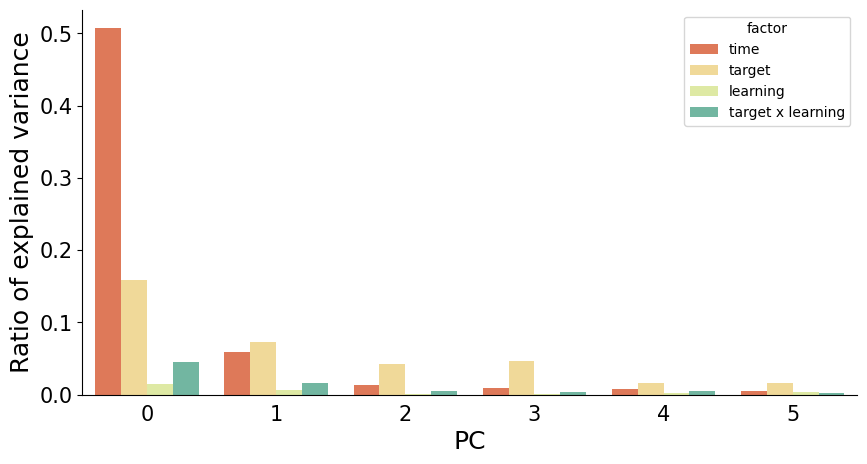

In [62]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(var_df, x='pc', y='variance_explained', hue='factor', palette=sns.color_palette('Spectral',4))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False) 
ax.set_xlabel('PC', fontsize = fontsize_label)
ax.set_ylabel('Ratio of explained variance', fontsize = fontsize_label)

fig.savefig(os.path.join(save_fig,'dpca.pdf'),dpi=300,bbox_inches='tight')

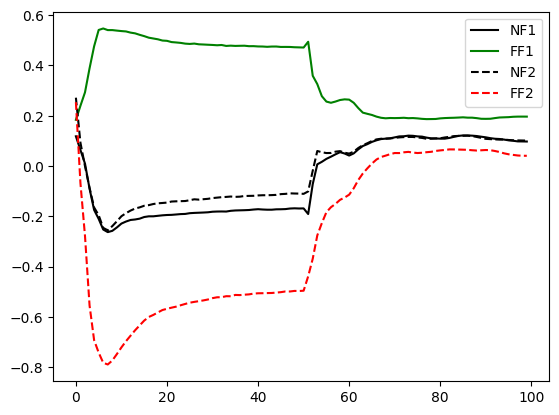

In [63]:
linestyle = ['-', '-', '--', '--']
color_list = ['k','g','k','r']
label=['NF1','FF1','NF2','FF2']

fig,ax = plt.subplots(1,1)
for i in range(len(x)):
    ax.plot(np.mean(x[i][:,:,0],axis=0).T,color=color_list[i],label=label[i],linestyle=linestyle[i])
    #ax.plot(x[i][:,:,0].T,linestyle=linestyle[i])
ax.legend()

In [129]:
model_name = 'model00'
U = get_data(folder_name, model_name, is_channel=False, n_hidden=128)
X = np.concatenate([np.array(d['all_hidden'][:,None,:,:]) for d in U], axis=1)
X = X.transpose(3,0,1,2)  # neurons x movements x conditions x time


In [161]:
model_name = 'model00'
U = get_data(folder_name, model_name, is_channel=False, n_hidden=128)
X = np.concatenate([np.array(d['all_hidden'][:,None,:,:]) for d in U], axis=1)
X = X.transpose(3,0,1,2)  # neurons x movements x conditions x time

go_cue, end_time = 3, 30

X_nf1 = X[:, :, 0, go_cue:end_time]
X_ff1 = X[:, :, 1, go_cue:end_time]
X_nf2 = X[:, :, 2, go_cue:end_time]
X_ff2 = X[:, :, 3, go_cue:end_time]

# Global mean across all conditions
mean_global = np.mean(X[:, :, :, go_cue:end_time], axis=(1, 2, 3))

X_nf1_centered = X_nf1 - mean_global[:, None, None]
X_ff1_centered = X_ff1 - mean_global[:, None, None]
X_nf2_centered = X_nf2 - mean_global[:, None, None]
X_ff2_centered = X_ff2 - mean_global[:, None, None]

# Fit PCA on all data
X_all = np.concatenate([X_nf1_centered.transpose(1,2,0).reshape(-1, X_nf1_centered.shape[0]),
                        X_ff1_centered.transpose(1,2,0).reshape(-1, X_ff1_centered.shape[0]),
                        X_nf2_centered.transpose(1,2,0).reshape(-1, X_nf2_centered.shape[0]),
                        X_ff2_centered.transpose(1,2,0).reshape(-1, X_ff2_centered.shape[0])], axis=0)
pca = PCA(n_components=3)
pca.fit(X_all)

colormap = plt.cm.viridis
colors = [colormap(i/7) for i in range(8)]

fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})

dist_nf1_ff1_all = []
dist_nf2_ff2_all = []

# Subplot 1: NF1 vs FF1
for mov in range(8):
    traj_nf1 = pca.transform(X_nf1_centered[:, mov, :].T)
    traj_ff1 = pca.transform(X_ff1_centered[:, mov, :].T)
    
    axes[0].plot(traj_nf1[:, 0], traj_nf1[:, 1], traj_nf1[:, 2], color=colors[mov], linewidth=2)
    axes[0].plot(traj_ff1[:, 0], traj_ff1[:, 1], traj_ff1[:, 2], color=colors[mov], linewidth=2, linestyle='--')
    
    dist_nf1_ff1 = np.mean(np.linalg.norm(traj_nf1 - traj_ff1, axis=1))
    dist_nf1_ff1_all.append(dist_nf1_ff1)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=fontsize_label)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=fontsize_label)
axes[0].set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=fontsize_label)
axes[0].set_title('NF1 (solid) vs FF1 (dashed)', fontsize=fontsize_label)

# Subplot 2: NF2 vs FF2
for mov in range(8):
    traj_nf2 = pca.transform(X_nf2_centered[:, mov, :].T)
    traj_ff2 = pca.transform(X_ff2_centered[:, mov, :].T)
    
    axes[1].plot(traj_nf2[:, 0], traj_nf2[:, 1], traj_nf2[:, 2], color=colors[mov], linewidth=2)
    axes[1].plot(traj_ff2[:, 0], traj_ff2[:, 1], traj_ff2[:, 2], color=colors[mov], linewidth=2, linestyle='--')
    
    dist_nf2_ff2 = np.mean(np.linalg.norm(traj_nf2 - traj_ff2, axis=1))
    dist_nf2_ff2_all.append(dist_nf2_ff2)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=fontsize_label)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=fontsize_label)
axes[1].set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=fontsize_label)
axes[1].set_title('NF2 (solid) vs FF2 (dashed)', fontsize=fontsize_label)

plt.tight_layout()
plt.show()

print(f"\nMean distance NF1-FF1: {np.mean(dist_nf1_ff1_all):.3f} ± {np.std(dist_nf1_ff1_all):.3f}")
print(f"Mean distance NF2-FF2: {np.mean(dist_nf2_ff2_all):.3f} ± {np.std(dist_nf2_ff2_all):.3f}")



Mean distance NF1-FF1: 0.468 ± 0.177
Mean distance NF2-FF2: 0.461 ± 0.206


In [145]:
go_cue, end_time = 3, 30
n_models = 40

dist_nf1_ff1_models = []
dist_nf2_ff2_models = []

for mn in range(n_models):
    model_name = f'model{mn:02d}'
    U = get_data(folder_name, model_name, is_channel=False, n_hidden=128)
    
    X = np.concatenate([np.array(d['all_hidden'][:,None,:,:]) for d in U], axis=1)
    X = X.transpose(3,0,1,2)
    
    X_nf1 = X[:, :, 0, go_cue:end_time]
    X_ff1 = X[:, :, 1, go_cue:end_time]
    X_nf2 = X[:, :, 2, go_cue:end_time]
    X_ff2 = X[:, :, 3, go_cue:end_time]
    
    # Calculate distances across all movements and time
    dist_nf1_ff1 = np.mean(np.linalg.norm(X_nf1 - X_ff1, axis=0))
    dist_nf2_ff2 = np.mean(np.linalg.norm(X_nf2 - X_ff2, axis=0))
    
    dist_nf1_ff1_models.append(dist_nf1_ff1)
    dist_nf2_ff2_models.append(dist_nf2_ff2)

# Create DataFrame for plotting
import pandas as pd
df = pd.DataFrame({
    'Distance': dist_nf1_ff1_models + dist_nf2_ff2_models,
    'Condition': ['NF1-FF1']*n_models + ['NF2-FF2']*n_models
})



In [146]:
# Plot
fig, ax = plt.subplots(figsize=(3, 4))
sns.barplot(data=df, x='Condition', y='Distance', hue='Condition', ax=ax, palette=['gray', 'black'], legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Distance', fontsize=fontsize_label)
ax.set_xlabel('', fontsize=fontsize_label)
ax.tick_params(labelsize=fontsize_tick)
plt.tight_layout()
plt.show()

print(f"NF1-FF1: {np.mean(dist_nf1_ff1_models):.3f} ± {np.std(dist_nf1_ff1_models):.3f}")
print(f"NF2-FF2: {np.mean(dist_nf2_ff2_models):.3f} ± {np.std(dist_nf2_ff2_models):.3f}")


NF1-FF1: 0.725 ± 0.128
NF2-FF2: 0.720 ± 0.108


In [6]:
go_cue, end_time = 50, 100
n_models = 40

dist_nf1_ff1_time = []
dist_nf2_ff2_time = []

for mn in range(n_models):
    model_name = f'model{mn:02d}'
    U = get_data(folder_name, model_name, is_channel=False, n_hidden=128)
    
    X = np.concatenate([np.array(d['all_hidden'][:,None,:,:]) for d in U], axis=1)
    X = X.transpose(3,0,1,2)
    
    X_nf1 = X[:, :, 0, go_cue:end_time]
    X_ff1 = X[:, :, 1, go_cue:end_time]
    X_nf2 = X[:, :, 2, go_cue:end_time]
    X_ff2 = X[:, :, 3, go_cue:end_time]
    
    # Calculate distance at each timepoint (average across movements)
    dist_nf1_ff1 = np.mean(np.linalg.norm(X_nf1 - X_ff1, axis=0), axis=0)  # shape: (time,)
    dist_nf2_ff2 = np.mean(np.linalg.norm(X_nf2 - X_ff2, axis=0), axis=0)  # shape: (time,)
    
    dist_nf1_ff1_time.append(dist_nf1_ff1)
    dist_nf2_ff2_time.append(dist_nf2_ff2)

dist_nf1_ff1_time = np.array(dist_nf1_ff1_time)  # shape: (n_models, time)
dist_nf2_ff2_time = np.array(dist_nf2_ff2_time)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
time = np.arange(end_time - go_cue)

ax.plot(time, np.mean(dist_nf1_ff1_time, axis=0), color='gray', linewidth=2, label='NF1-FF1')
ax.fill_between(time, 
                np.mean(dist_nf1_ff1_time, axis=0) - np.std(dist_nf1_ff1_time, axis=0),
                np.mean(dist_nf1_ff1_time, axis=0) + np.std(dist_nf1_ff1_time, axis=0),
                color='gray', alpha=0.3)

ax.plot(time, np.mean(dist_nf2_ff2_time, axis=0), color='black', linewidth=2, label='NF2-FF2')
ax.fill_between(time, 
                np.mean(dist_nf2_ff2_time, axis=0) - np.std(dist_nf2_ff2_time, axis=0),
                np.mean(dist_nf2_ff2_time, axis=0) + np.std(dist_nf2_ff2_time, axis=0),
                color='black', alpha=0.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time', fontsize=fontsize_label)
ax.set_ylabel('Distance', fontsize=fontsize_label)
ax.tick_params(labelsize=fontsize_tick)
ax.legend(fontsize=fontsize_legend)
plt.tight_layout()
plt.show()
